# Model Demo
This notebook serves to give a simple demo of the `PoseEstimator` and how pretrained weights can be used with it to simply use a pretrained model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

We create an instance of the pose estimator. Next we load the pretrained weights for this model.

In [3]:
from openpose_cycling.model import PoseEstimator

pose_estimator = PoseEstimator()

pretrained_weights = './model.h5'
pose_estimator.model.load_weights(pretrained_weights, by_name=True)

As a demo we use an image of Chritopher Froome during the Giro d'Italia in 2018. We load this using `OpenCV`. Some care needs to be taken since by default `OpenCV` loads images in BGR format.

In [4]:
import os
import cv2

data_dir = '../data'
image_name = 'sample_image.jpg'

demo_img_path = os.path.join(data_dir, image_name)

image = cv2.imread(demo_img_path)

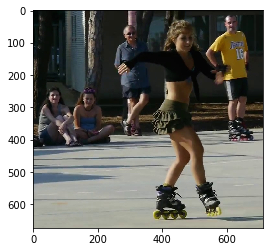

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image[..., [2, 1, 0]])

Next, we plot the heatmap as outputted by the model per joint. This heatmap indicates regions of interest where joints are located.

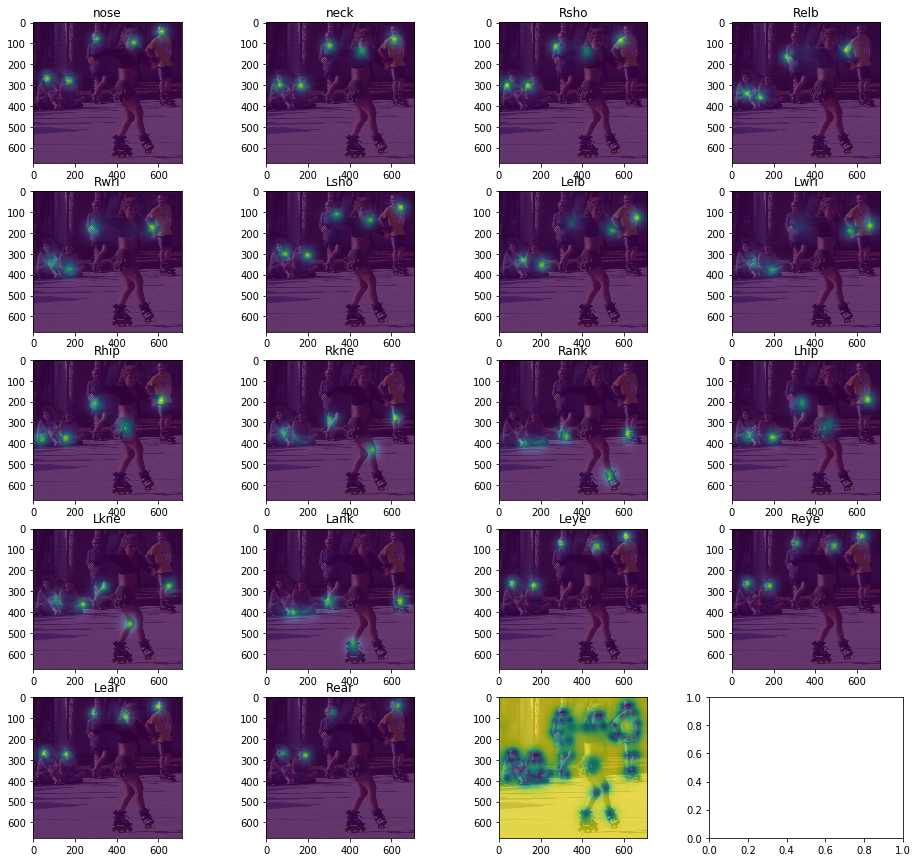

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from openpose_cycling import config as c
import math

N_COLS = 4
N_ROWS = math.ceil(len(c.ELEMENTS_MAP) / 4)

paf, heatmap = pose_estimator.predict_paf_and_heatmap(image[None,...,])
paf = paf[0]
heatmap = heatmap[0]
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(N_COLS*4, N_ROWS*3))

for (el_id, name), ax in zip(c.ELEMENTS_MAP.items(), np.reshape(axs, (-1,))):
    ax.imshow(image[..., [2, 1, 0]])
    ax.imshow(heatmap_resized[..., el_id], alpha=0.7)
    
    ax.set_title(name)

The following plots show how the heatmaps are transformed into point estimates for all the joints.

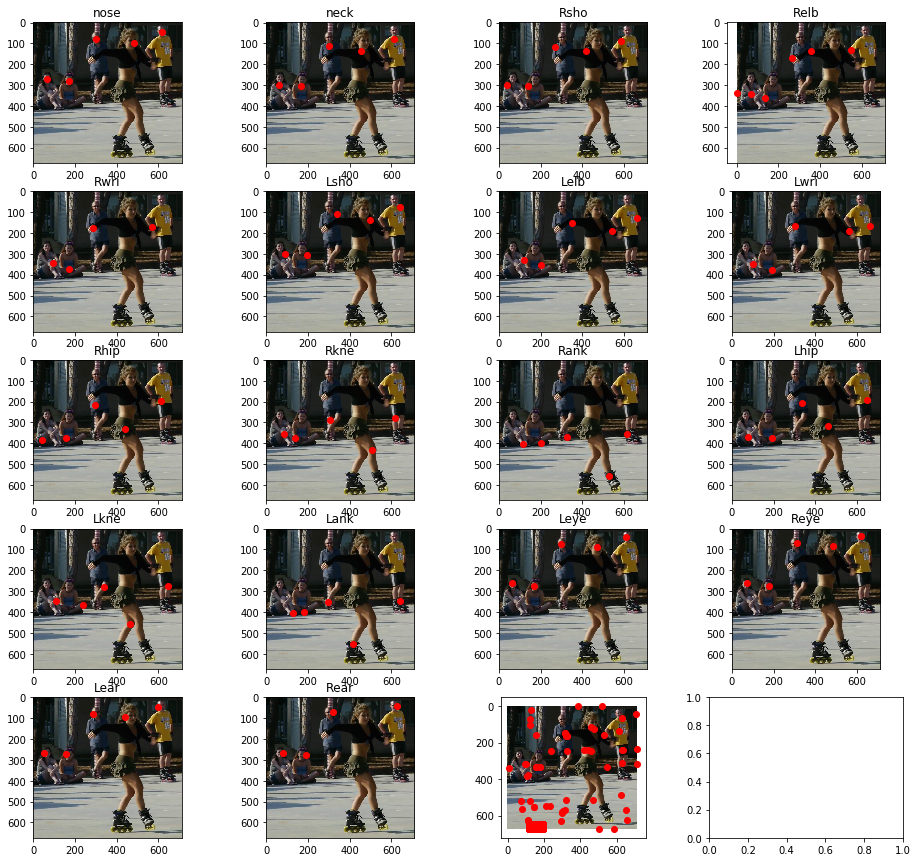

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from openpose_cycling import config as c
import math

N_COLS = 4
N_ROWS = math.ceil(len(c.ELEMENTS_MAP) / 4)


joints = pose_estimator.predict_from_image(image[None,...])[0]
fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(N_COLS*4, N_ROWS*3))

for (el_id, name), ax in zip(c.ELEMENTS_MAP.items(), np.reshape(axs, (-1,))):
    ax.imshow(image[..., [2, 1, 0]])
    ax.scatter(joints[el_id][0], joints[el_id][1], c='r')
    
    ax.set_title(name)

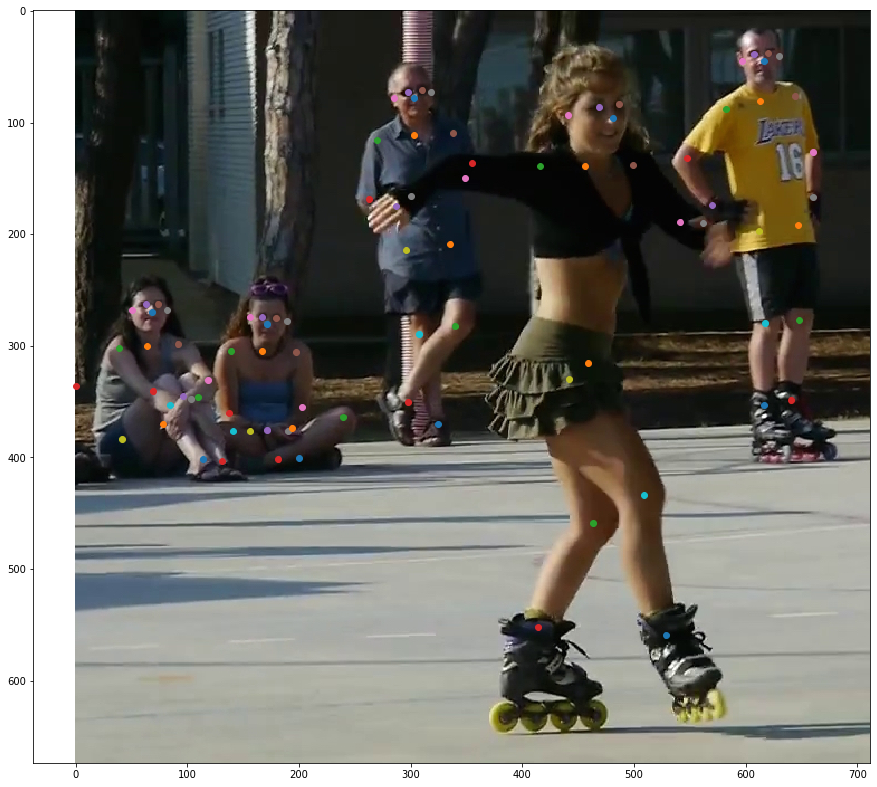

In [8]:
plt.figure(figsize=(15,15))

plt.imshow(image[..., [2, 1, 0]])
for joint_coords in joints[:-1]:
    plt.scatter(joint_coords[0], joint_coords[1])

# PAF linking

In [10]:
import matplotlib

In [11]:
import numpy.ma as ma

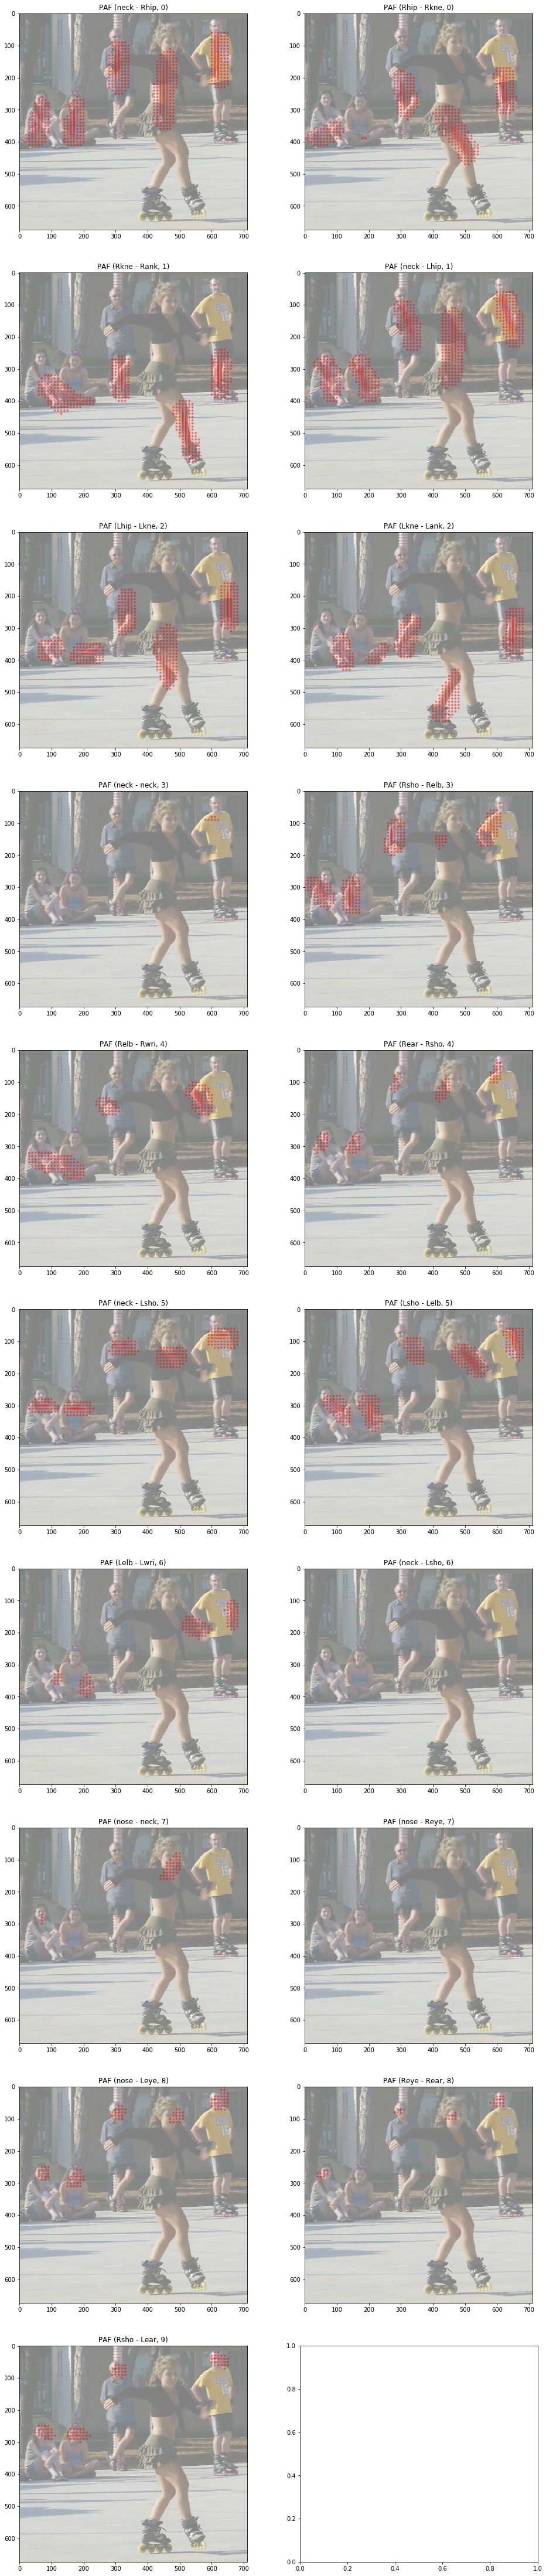

In [138]:
N_COLS = 2
N_ROWS = math.ceil(len(c.ELEMENTS_MAP) / N_COLS)
s = 10

fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(N_COLS*8, N_ROWS*8))
axs = axs.reshape(-1)



for i, paf_orig_shape in enumerate(np.rollaxis(paf, axis=-2)):
    joint_1_id, joint_2_id = c.LINKS[i]
    joint_1_name, joint_2_name = c.ELEMENTS[joint_1_id], c.ELEMENTS[joint_2_id]
    ax = axs[i]
    
    paf_rezied = cv2.resize(paf_orig_shape, (image.shape[1], image.shape[0]))
    U = paf_rezied[:,:,0] * -1
    V = paf_rezied[:,:,1]
    X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
    M = np.zeros(U.shape, dtype='bool')
    M[U**2 + V**2 < 0.1 * 0.1] = True
    U = ma.masked_array(U, mask=M)
    V = ma.masked_array(V, mask=M)
    
    ax.set_title('PAF (%s - %s, %d)' % ((joint_1_name, joint_2_name, i // 2)))
    ax.imshow(image[:,:,[2,1,0]], alpha = .5)
    Q = ax.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
                  scale=50, headaxislength=10, alpha=.5, width=0.01, color='r')

In [334]:
DESIRED_LINK_ID = 2
joint_1_id, joint_2_id = c.LINKS[DESIRED_LINK_ID]
joint_1_name, joint_2_name = c.ELEMENTS[joint_1_id], c.ELEMENTS[joint_2_id]

paf_for_link = paf[..., DESIRED_LINK_ID, :]
paf_for_link_orig_shape = cv2.resize(paf_for_link, (image.shape[1], image.shape[0]))

start = joints[joint_1_id].T.astype('int')
stop = joints[joint_2_id].T.astype('int')

print("We are matching %s and %s" % (joint_1_name, joint_2_name))

We are matching Rkne and Rank


In [335]:
def lines_between(start_coords, stop_coords, n_steps=100):
    x_grad = (start_coords[None, :, 0] - stop_coords[None, :, 0].T)
    y_grad = (start_coords[None, :, 1] - stop_coords[None, :, 1].T)
    # Transpose to make x, y ordering more intuitive
    grads = np.concatenate([x_grad[..., None], y_grad[..., None]], axis=-1).transpose([1, 0, 2])
    
    alpha = np.linspace(0, 1, num=n_steps)
    
    # Create the line segments and transpose such that the first index matches the index
    # in the start array and the last index matches that in the end array. This should be
    # more intuitive.
    x_lines = (start[:, 0] - alpha[:, None, None] * x_grad[None, ...]).transpose([0, 2, 1])
    y_lines = (start[:, 1] - alpha[:, None, None] * y_grad[None, ...]).transpose([0, 2, 1])
    
    lines = np.concatenate([x_lines[..., None], y_lines[..., None]], axis=-1)
    return lines, grads
    

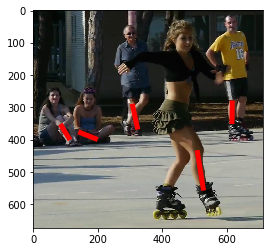

In [336]:
from scipy.optimize import linear_sum_assignment

def match_joints_based_on_paf(paf, joints_1, joints_2):
    """
    Uses the PAF to find the most likely matches between pairs of joints.
    
    Args:
        paf (3d-NumPy Array): A height x width x 2 array with the Part Affinity field
            for the joints to evaluate.
        joints_1 (2d-NumPy Array): n x 2 array with the last dimension corresponding to the x and the y
            coordinate of a detected joint.
        joints_2 (2d-NumPy Array): n x 2 array with the last dimension corresponding to the x and the y
            coordinate of a detected joint.
            
    Returns:
        list of tuple: List of tuples where the first element represents the index in the first
            array of joints past and the second element that in the second set of joints.
    """
    lines, grads = lines_between(joints_1, joints_2, n_steps=100)
    normed_grads = grads / np.linalg.norm(grads, axis=-1)[..., None]
                                 
    x_ind = lines[..., 0].astype('int')
    y_ind = lines[..., 1].astype('int')    
    
    # We invert the direction of the y direction of the PAF because indexing images works
    # by starting in the top left
    paf_along_line = paf[y_ind, x_ind]

    # All vectors have norm 1 so cosine similarity becomes easy
    similarity = (paf_along_line * -1 * normed_grads).sum(axis=-1)
    integrated_similarity_along_lines = similarity.mean(axis=0)
    
    # Maxize the total integrated similarity by connecting all points
    first_point, second_point = linear_sum_assignment(-1 * integrated_similarity_along_lines)
    
    return list(zip(first_point, second_point))


matches = match_joints_based_on_paf(paf_for_link_orig_shape, start, stop)

from matplotlib import collections as mc

fig, ax = plt.subplots()

ax.imshow(image[..., [2, 1, 0]])

segments = [(start[id_1], stop[id_2])for id_1, id_2 in matches]
ax.add_collection(mc.LineCollection(segments, colors='r', linewidths=5))